## Load and Preprocess

#### Importing Libraries

In [ ]:
#Installing the needed libraries
!pip install librosa tensorflow matplotlib

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
from tensorflow.keras.utils import to_categorical
import shutil
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
screaming_file_path = '/content/drive/My Drive/DeepLearning/code/dataset/Screaming'
notScreaming_file_path = '/content/drive/My Drive/DeepLearning/code/dataset/NotScreaming'
train_file_path = '/content/drive/My Drive/DeepLearning/Train_audios'

In [5]:

WINDOW_LENGTH = 0.025
HOP_LENGTH = 0.01
max_length = 10.0

def pad_audio(audio, sr, max_length):
    max_len_samples = int(max_length * sr)
    if len(audio) < max_len_samples:
        padding = max_len_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    else:
        audio = audio[:max_len_samples]
    return audio

def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs

def get_melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                       fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(WINDOW_LENGTH * fs)
    if hop_length is None:
        hop_length = int(HOP_LENGTH * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def preview_melspectrogram(spectrogram=None, filename='spectrogram.png'):
    """Save a given spectrogram as an image."""

    if spectrogram is None:
        raise AssertionError

    import matplotlib.pyplot as plt
    import librosa.display

    plt.figure(figsize=(10, 4))
    # Spectrogram already in mel scale
    librosa.display.specshow(spectrogram)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.savefig(filename)
    return plt

def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    print(spectrogram)
    spectrogram = spectrogram[:128]
    return spectrogram.T

In [8]:
def load_and_preprocess_data(screaming_folder,notScreaming_folder):
    features = []
    labels = []
    file_paths = []

    for file in os.listdir(screaming_folder):
        file_path = os.path.join(screaming_folder, file)
        if os.path.isfile(file_path):
            x, fs = load_wav(file_path)
            x = pad_audio(x, fs, max_length)
            mel_spectrogram = get_melspectrogram(x, fs)
            features.append(mel_spectrogram)
            labels.append('1')
            file_paths.append(file_path)

    for file in os.listdir(notScreaming_folder):
        file_path = os.path.join(notScreaming_folder, file)
        if os.path.isfile(file_path):
            x, fs = load_wav(file_path)
            x = pad_audio(x, fs, max_length)
            mel_spectrogram = get_melspectrogram(x, fs)
            features.append(mel_spectrogram)
            labels.append('0')
            file_paths.append(file_path)

    X = np.array(features)  # Keep the 3D shape (num_samples, time_steps, n_mels)
    y = np.array(labels)

    le = LabelEncoder()
    y = le.fit_transform(y)

    y = to_categorical(y)

    X_train, X_temp, y_train, y_temp, file_paths_train, file_paths_temp = train_test_split(X, y, file_paths, train_size=0.8, random_state=42)
    X_val, X_test, y_val, y_test, file_paths_val, file_paths_test = train_test_split(X_temp, y_temp, file_paths_temp, train_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test, file_paths_train, file_paths_val, file_paths_test

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test, file_paths_train, file_paths_val, file_paths_test = load_and_preprocess_data(screaming_file_path, notScreaming_file_path )

In [10]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2794, 1001, 128)
X_val shape: (349, 1001, 128)
X_test shape: (350, 1001, 128)
y_train shape: (2794, 2)
y_val shape: (349, 2)
y_test shape: (350, 2)


Save the X_train, y_train, X_test, y_test, X_val, y_val arrays as .npy files in order to use them to our NN models

In [11]:
save_path = '/content/drive/My Drive/DeepLearning/'

# Save arrays as .npy files
np.save(save_path + 'X_train.npy', X_train)
np.save(save_path + 'X_val.npy', X_val)
np.save(save_path + 'X_test.npy', X_test)
np.save(save_path + 'y_train.npy', y_train)
np.save(save_path + 'y_val.npy', y_val)
np.save(save_path + 'y_test.npy', y_test)

Saving train audios in a folder, that will be useful to our next steps, such as to data augmentation.

In [12]:
def save_train_audios(file_paths_train, y_train, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_path, label in zip(file_paths_train, y_train):
        file_name = os.path.basename(file_path)
        class_label = label.argmax()  # Convert one-hot encoding to integer label
        new_file_name = f"{os.path.splitext(file_name)[0]}_{class_label}.wav"
        shutil.copy(file_path, os.path.join(output_folder, new_file_name))

In [13]:
import shutil
save_train_audios(file_paths_train, y_train, train_file_path)

Bar plots depicting the distribution of classes across training, validation, and test datasets.

Showing the bar plots of Train Dataset, Validation Dataset, and Test Dataset


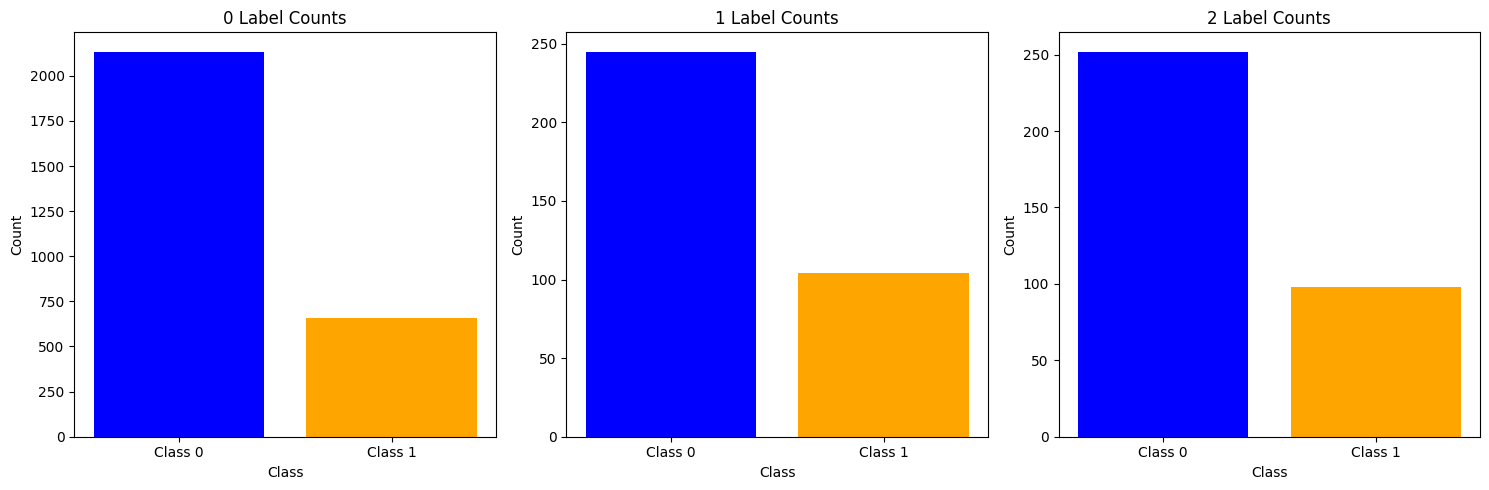

In [14]:
import matplotlib.pyplot as plt


arrays = [y_train, y_val, y_test]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print('Showing the bar plots of Train Dataset, Validation Dataset, and Test Dataset')
for i, arr in enumerate(arrays):
    class_counts = np.sum(arr, axis=0)
    axes[i].bar(np.arange(len(class_counts)), class_counts, color=['blue', 'orange'])
    axes[i].set_title(f'{i} Label Counts')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(np.arange(len(class_counts)))
    axes[i].set_xticklabels(['Class 0', 'Class 1'])
plt.tight_layout()
plt.show()